# Restricted Boltzman Machine (Assignment 3)

Giulia Ghisolfi, 664222

# 2. Code Implementation

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.datasets import mnist
from numpy import random
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## 2.1 RBM Implementation

Implementation of a class that represents a Restricted Boltzmann Machine using the CD-1 training algorithm. \
Weights and biases are initialized using a Gaussian distribution with a mean of 0 and a standard deviation of 0.1. \
The class offers the possibility to use some variants of the algorithm such as stochastic, mini-batch, and batch as weight update policies, momentum regularization, early stopping techniques and convergence on validation error as stopping criteria.

In [45]:
def sigmoid(x):
    """Sigmoid Activation Function"""
    return np.array(1 / (1 + np.exp(-x)))

def MSE(data, reconstructed_data):
    """Mean Squared Error (MSE) Loss"""
    return np.mean(np.mean(np.power(data - reconstructed_data, 2)))

In [55]:
class RBM:

    def __init__(self, hidden_unit, X_train, X_test=None, X_reconstruction=None, epochs=500, learning_rate=0.01, momentum=0.9,
                 batch_size=None, early_stoppig=False, verbose=False, stopping_patience=10, convergence_tol=0.00001,
                 metric_decrease_tol=0.00001, validation_size=0.2, show_reconstruction=False, show_learning_curve=False,
                 weights=None, visible_bias=None, hidden_bias=None):

        self.n_hidden = hidden_unit  # hidden unit cardinality
        self.n_visible = X_train.shape[1]  # visible unit cardinality
        self.epochs = epochs # max number of epochs
        self.learning_rate = learning_rate
        self.alpha = momentum
        self.batch_size = batch_size
        self.early_stopping = early_stoppig # (bool)
        self.verbose = verbose # (bool)
        self.stopping_patience = stopping_patience # number of iterations to wait for improvement before stopping training
        self.convergence_tol = convergence_tol
        self.metric_decrease_tol = metric_decrease_tol
        self.validation_size = validation_size
        self.show_reconstr = show_reconstruction # (bool)
        self.show_curve = show_learning_curve # (bool)

        if (weights is not None) and (visible_bias is not None) and (hidden_bias is not None):
            self._set_weights(weights, visible_bias, hidden_bias)
        else: self._init_wegths_and_bias()

        self._fit(X_train, X_test, X_reconstruction)

    def _init_wegths_and_bias(self):
        """init weights and bias"""
        self.M = random.normal(loc=0, scale=0.1, size=(self.n_visible, self.n_hidden))  # weights matrix
        self.b = random.normal(loc=0, scale=0.1, size=(1, self.n_visible))  # visible units bias
        self.c = random.normal(loc=0, scale=0.1, size=(1, self.n_hidden))  # hidden units bias

    def _fit(self, X_train, X_test, X_reconstruction):
        """fit the dataset for training, validation end showing the progress of image reconstruction"""
        self.X_train = X_train
        self.X_val = X_test

        if self.early_stopping and X_test is None:
            self.X_train, self.X_val = train_test_split(
                X_train, test_size=self.validation_size, shuffle=True)
        if not self.batch_size: self.batch_size = X_train.shape[0]

        if X_reconstruction is not None:
            self.X_reconstruction = X_reconstruction
            self.show_reconstr = True
        if self.show_reconstr and X_reconstruction is None:
            self.X_reconstruction = shuffle(X_train, random_state=None)[0:4]

    def train(self):
        """trainig RBM model using the CD-1 training algorithm"""
        # init
        self.no_improvement_count = 0
        self.tr_errors = []
        if self.X_val is not None:
            self.val_errors = []
        else:
            self.val_errors = None
        velocity_M = 0
        velocity_b = 0
        velocity_c = 0

        # divide training set into batches
        self.X_train = shuffle(self.X_train, random_state=None)
        n_batches = np.ceil(self.X_train.shape[0] / self.batch_size)
        X_train_batched = np.array_split(self.X_train, n_batches)

        # CD-1 training algorithm
        for epoch in range(self.epochs):
            # loop through batches
            for i, X_batch in enumerate(X_train_batched):
                # compute wake phase
                v0_state = X_batch  # bynary input
                h0_act = np.dot(v0_state, self.M) + self.c
                h0_prob = sigmoid(h0_act)  # hidden activation probability
                wake = np.dot(v0_state.T, h0_prob)

                # compute dream phase
                h0_state = (h0_prob > random.rand(h0_prob.shape[0], h0_prob.shape[1])).astype(int)  # hidden activation
                v1_act = np.dot(h0_state, self.M.T) + self.b
                v1_prob = sigmoid(v1_act)  # data reconstruction probability
                v1_state = (v1_prob > random.rand(v1_prob.shape[0], v1_prob.shape[1])).astype(int)  # reconstructed data
                h1_act = np.dot(v1_state, self.M) + self.c
                h1_prob = sigmoid(h1_act)
                dream = np.dot(v1_state.T, h1_prob)

                if self.verbose:
                    # compute reconstruction error
                    error = MSE(v0_state, v1_state)
                    print("Batch %d/%d, reconstruction error=%.6f" %
                          (i+1, n_batches, error))

                # compute and normalize the accumulated deltas dividing by the batch size
                n_patterns = X_batch.shape[0]
                delta_M = (wake - dream) / n_patterns
                delta_b = np.sum(v0_state - v1_state, axis=0) / n_patterns
                delta_c = np.sum(h0_prob - h1_prob, axis=0) / n_patterns

                # compute weights and biases velocities to apply momentum
                velocity_M = self.alpha * velocity_M + self.learning_rate * delta_M
                velocity_b = self.alpha * velocity_b + self.learning_rate * delta_b
                velocity_c = self.alpha * velocity_c + self.learning_rate * delta_c

                # weights and bias update
                self.M += velocity_M
                self.b += velocity_b
                self.c += velocity_c

            # compute reconstruction error
            tr_error = self.compute_reconstruction_error(self.X_train)
            self.tr_errors.append(tr_error)

            # validation
            if self.X_val is not None or self.early_stopping:
                val_error = self.compute_reconstruction_error(self.X_val)
                self.val_errors.append(val_error)

                print("Epoch %d/%d, train loss=%.6f, val loss=%.6f"
                      % (epoch+1, self.epochs, tr_error, val_error))

            else:
                print("Epoch %d/%d, train loss=%.6f" %
                      (epoch+1, self.epochs, tr_error))

            # show current image reconstruted
            if self.show_reconstr:
                self._show_current_reconstruction(self.X_reconstruction, epoch)

            # stopping criteria
            self._update_no_improvement_count(epoch, tr_error, val_error)

            if self.no_improvement_count >= self.stopping_patience:  # stopping criteria satisfied
                self._set_weights(self.best_M, self.best_b, self.best_c)
                break  # jump out the for loop

        if self.show_curve:
            self.show_learning_curve(self.tr_errors, self.val_errors)

    def _get_current_weights(self):
        M = self.M  # weights matrix
        b = self.b  # visible units bias
        c = self.c  # hidden units bias
        return M, b, c

    def _set_weights(self, M, b, c):
        self.M = M  # weights matrix
        self.b = b  # visible units bias
        self.c = c  # hidden units bias

    def _update_no_improvement_count(self, epoch, train_error, val_error):
        if epoch < 10:
            self.best_epoch = epoch
            self.best_error = val_error if self.early_stopping else train_error
            self.best_M, self.best_b, self.best_c = self._get_current_weights()
            return

        if self.early_stopping:
            converged = val_error <= self.convergence_tol
            best_error_delta = self.best_error - val_error
        else:
            converged = train_error <= self.convergence_tol
            best_error_delta = self.best_error - train_error

        if best_error_delta > 0:
            self.best_epoch = epoch
            self.best_train_error = train_error
            self.best_error = val_error if self.early_stopping else train_error
            self.best_M, self.best_b, self.best_c = self._get_current_weights()
        if converged: # if we've already converged (error near 0)
            self.no_improvement_count = self.stopping_patience
        elif best_error_delta < self.metric_decrease_tol:
            self.no_improvement_count += 1  # if no significant improvement
        else:
            self.no_improvement_count = 0

    def _show_current_reconstruction(self, data, epoch):
        reconstructed_image = self.compute_reconstructed_image(data)

        fig, axes = plt.subplots(1, len(reconstructed_image), figsize=(18,2))
        fig.suptitle("Epoch %d: image reconstruction" % (epoch+1))

        for i, image in enumerate(reconstructed_image):
            ax = axes[i]
            ax.imshow(image.reshape(28, 28), cmap="gray")
            ax.axis("off")
        plt.show()

    def _encode_data(self, data):
        hidden_act = np.dot(data, self.M) + self.c
        hidden_prob = sigmoid(hidden_act)  # hidden activation probability
        hidden_state = (hidden_prob > random.rand(
            hidden_prob.shape[0], hidden_prob.shape[1])).astype(int)  # hidden activation
        return hidden_state

    def _decode_data(self, hidden_state):
        visible_act = np.dot(hidden_state, self.M.T) + self.b
        visible_prob = sigmoid(visible_act)  # data reconstruction probability
        visible_state = (visible_prob > random.rand(
            visible_prob.shape[0], visible_prob.shape[1])).astype(int)  # reconstructed data
        return visible_state

    def compute_reconstruction_error(self, data):
        """Compute reconstruction error between a given flatten image and its reconstruction"""
        reconstructed_data = self.compute_reconstructed_image(data)
        return MSE(data, reconstructed_data)

    def compute_reconstructed_image(self, data):
        """Compute the reconstruction of a given flatten image"""
        encoded_data = self._encode_data(data)
        reconstructed_data = self._decode_data(encoded_data)
        return reconstructed_data

    def show_reconstruction(self, X_test):
        """Show image recostruction"""
        reconstructed_image = self.compute_reconstructed_image(X_test)

        fig, axes = plt.subplots(2, len(reconstructed_image), figsize=(18,4))
        for i in range(len(reconstructed_image)):
            ax = axes[0][i]
            ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
            ax.axis("off")
            ax.set_title("Original")

            ax = axes[1][i]
            ax.imshow(reconstructed_image[i].reshape(28, 28), cmap="gray")
            ax.axis("off")
            ax.set_title("Reconstructed")
        plt.show()

    def save_RBM(self, filename):
        """Save RBM parameters in a pickle file"""
        with open(filename, 'wb') as file:
            pickle.dump([self.n_hidden, self.X_train, self.X_reconstruction, self.X_val, self.epochs, self.learning_rate,
                         self.alpha, self.batch_size, self.early_stopping, self.verbose, self.stopping_patience,
                         self.convergence_tol, self.metric_decrease_tol, self.validation_size, self.show_recostr,
                         self.show_curve, self.best_M, self.best_b, self.best_c, self.tr_errors, self.val_errors,
                         self.best_epoch], file)


## 2.2 Utils

In [183]:
def flatten_data(X):
    return X.reshape(X.shape[0], -1)


def select_test_image(X_data, y_data):
    """Select one image for each digit"""
    X_data, y_data = shuffle(X_data, y_data, random_state=None)

    X_selected = []
    y_selected = []

    i = 0
    for image, value in zip(X_data, y_data):
        if value == i:
            X_selected.append(image)
            y_selected.append(i)
            i += 1

    return np.array(X_selected), np.array(y_selected)

def show_learning_curve(tr_errors, val_errors):
    plt.figure()
    plt.plot(tr_errors, label="Training error")
    if val_errors is not None:
        plt.plot(val_errors, label="Test error")

    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction Errors (MSE)")
    plt.show()

def load_RBM(filename):
    with open(filename, 'rb') as file:
        [hidden_unit, X_train, X_reconstruction, X_test, epochs, learning_rate, momentum, batch_size, early_stoppig,
         verbose, stopping_patience, convergence_tol, metric_decrease_tol, validation_size,
         show_reconstruction, show_learning_curve, weights, visible_bias, hidden_bias, tr_errors,
         val_errors, best_epoch] = pickle.load(file)

    rbm = RBM(hidden_unit, X_train, X_reconstruction, X_test, epochs, learning_rate, momentum, batch_size,
              early_stoppig, verbose, stopping_patience, convergence_tol, metric_decrease_tol, 
              validation_size, show_reconstruction, show_learning_curve, weights, visible_bias, hidden_bias)

    return rbm, tr_errors, val_errors, best_epoch


### 2.3 Load Dataset

Load the MNIST dataset from the Keras library. The images are flattened and converted to binary by applying a threshold to the value of each pixel.

In [50]:
def load_mnist():
    # MNIST dataset load from keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # gray scale images and labels

    # flatten data
    X_train = flatten_data(X_train)
    X_test = flatten_data(X_test)

    # convert to binary
    X_train = np.where(X_train > 127, 1, 0) # 60.000 images 28x28 pixel
    X_test = np.where(X_test > 127, 1, 0) # 10.000 images
    
    return X_train, y_train, X_test, y_test

In [51]:
X_train, y_train, X_test, y_test = load_mnist()

# select one image for each digit to show the progress of reconstruction through epoches
X_selected, y_test_selected = select_test_image(X_test, y_test)

### 2.4 RBM initialization

The network is trained using 500 hidden unit, 0.1 as fixed learning rate, momentum with coeficient 0.7, batch approach with size 200.
The stopping criteria were based on the convergence of the validation error, and an early stopping technique with a patience of 10 epochs was used to wait for improvement before stopping training.

These hyperparameters were chosen after conducting some preliminary trials.
A stochastic or mini-batch approach was not chosen as it did not significantly improve results and slowed down the training phase.
The number of hidden units was chosen to be high enough to reduce the number of epochs required to reach the same reconstruction error.

Weights regularization and variable learning rate approaches were not implemented as the results obtained were already satisfactory.

In [184]:
rbm = RBM(hidden_unit=500, X_train=X_train, X_test=X_test, X_reconstruction=X_selected, epochs=20, learning_rate=0.1, momentum=0.7,
            batch_size=200, early_stoppig=True, show_reconstruction=True)


### 2.5 Show Image Reconstruction Progress through Epoches

For visual purposes, the network is trained for 20 epochs, showing the reconstruction progress for each epoch of a randomly selected image for each digit from the test set.

Epoch 1/20, train loss=0.058860, val loss=0.058614


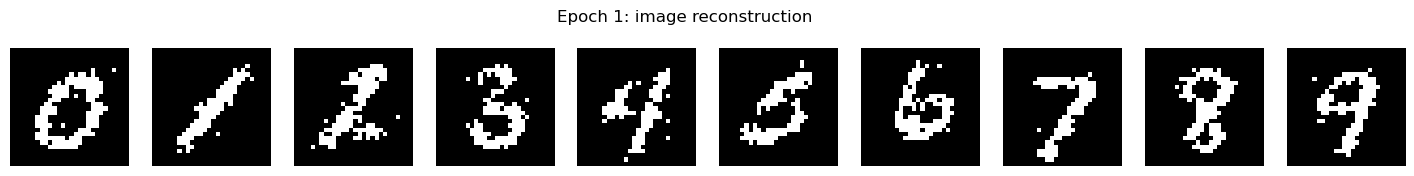

Epoch 2/20, train loss=0.048812, val loss=0.048788


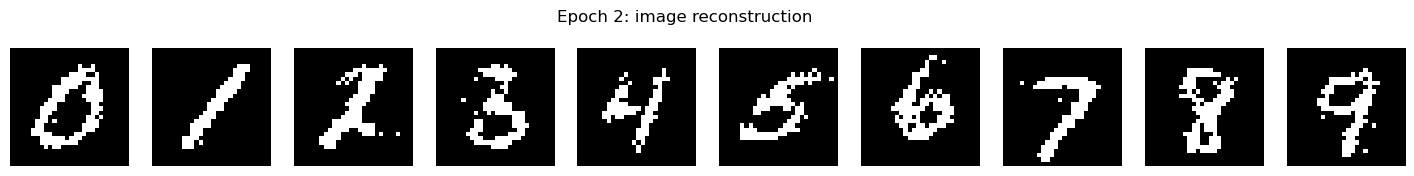

Epoch 3/20, train loss=0.043142, val loss=0.043251


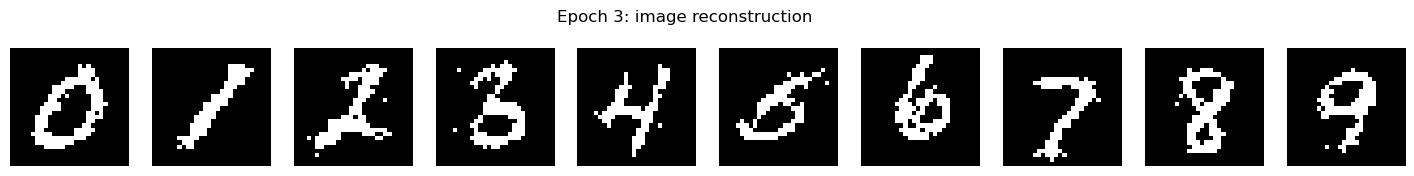

Epoch 4/20, train loss=0.039489, val loss=0.039705


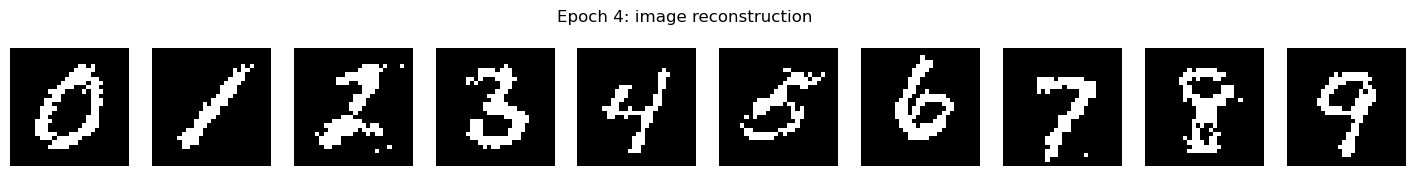

Epoch 5/20, train loss=0.036861, val loss=0.037217


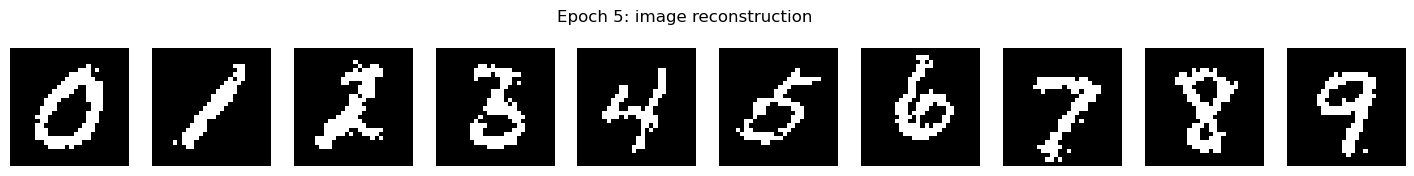

Epoch 6/20, train loss=0.035043, val loss=0.035378


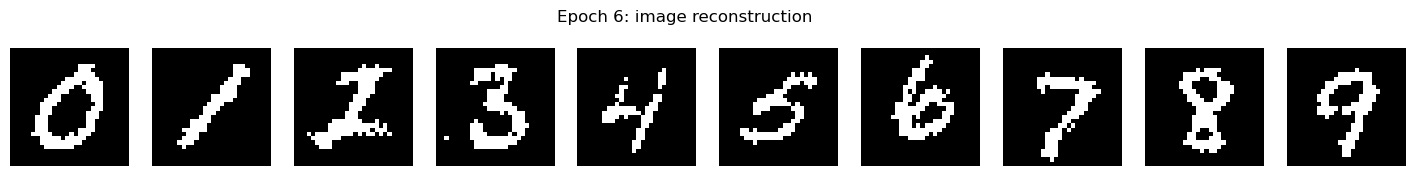

Epoch 7/20, train loss=0.033429, val loss=0.033916


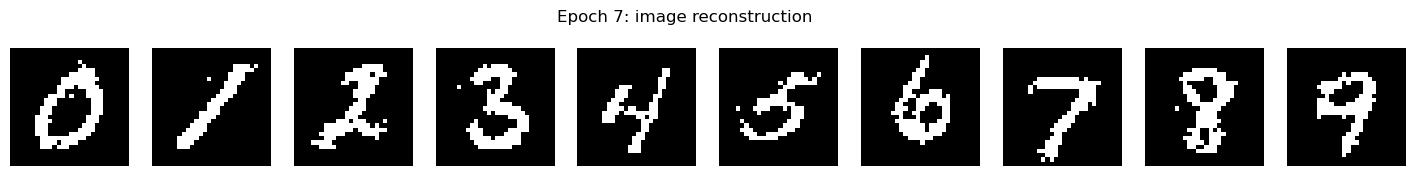

Epoch 8/20, train loss=0.032187, val loss=0.032676


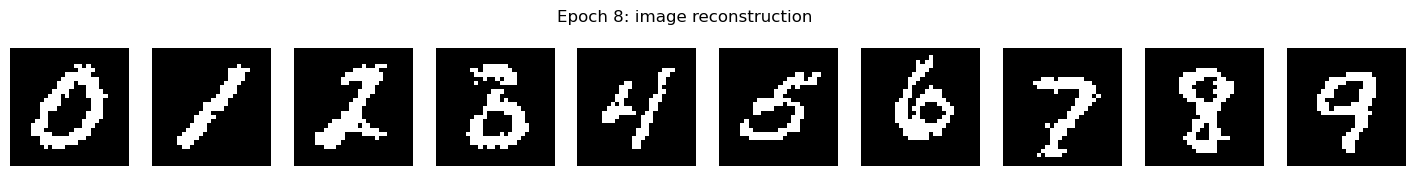

Epoch 9/20, train loss=0.031123, val loss=0.031711


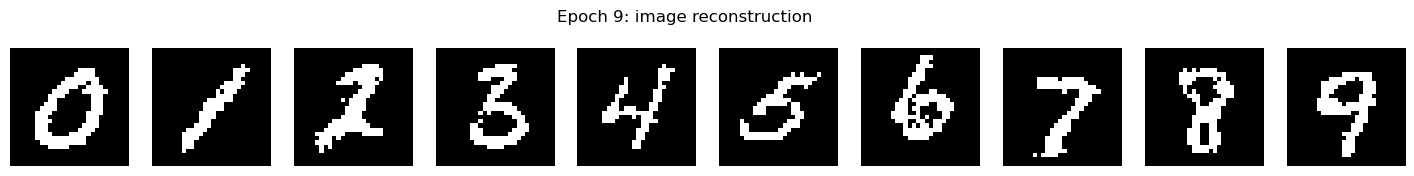

Epoch 10/20, train loss=0.030282, val loss=0.030796


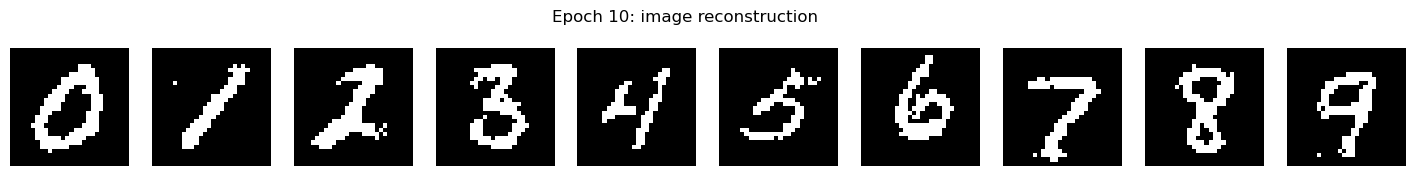

Epoch 11/20, train loss=0.029699, val loss=0.030353


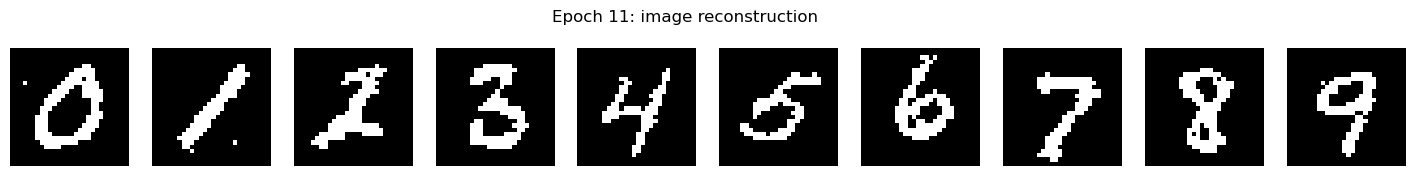

Epoch 12/20, train loss=0.028957, val loss=0.029521


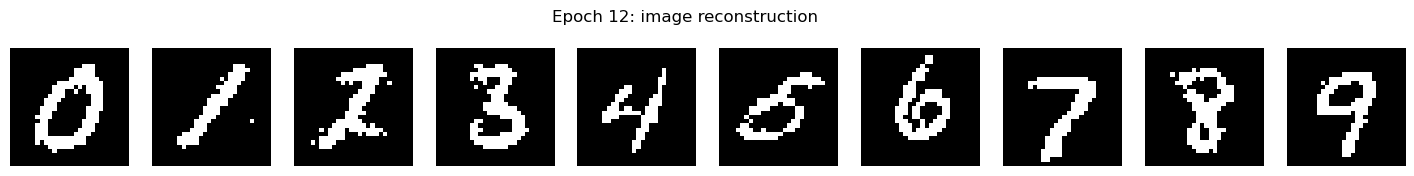

Epoch 13/20, train loss=0.028420, val loss=0.029049


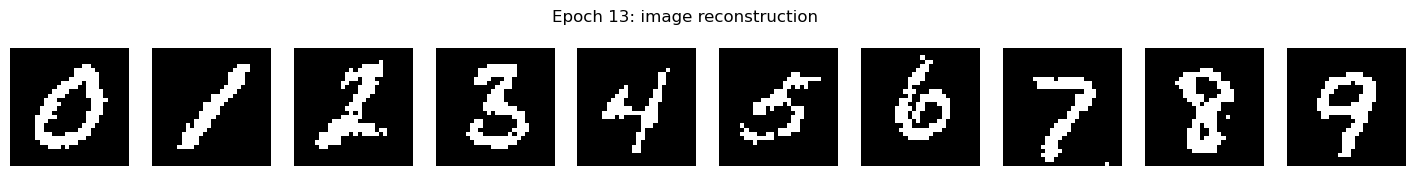

Epoch 14/20, train loss=0.027954, val loss=0.028628


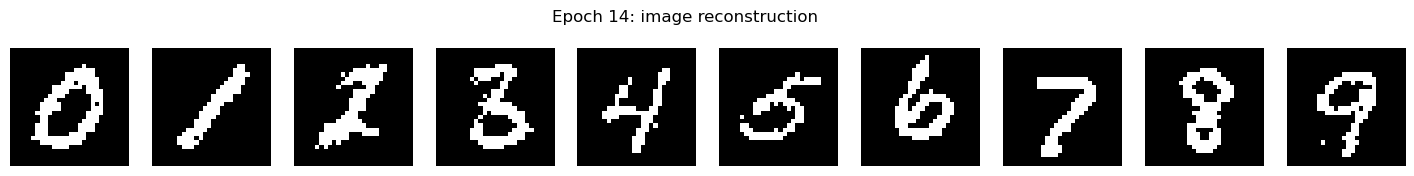

Epoch 15/20, train loss=0.027482, val loss=0.028239


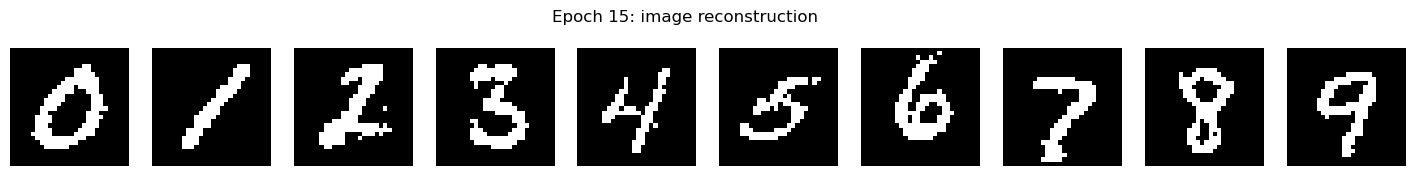

Epoch 16/20, train loss=0.027058, val loss=0.027859


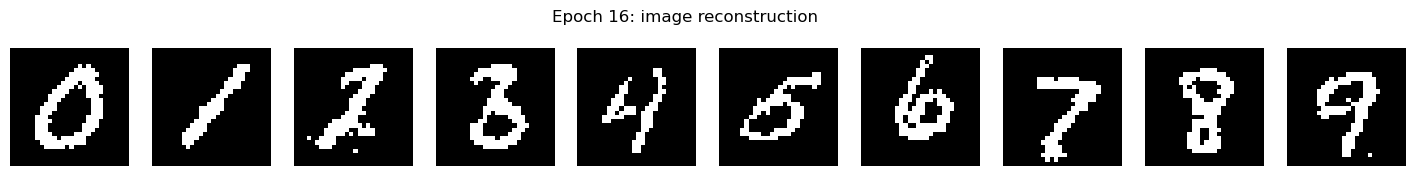

Epoch 17/20, train loss=0.026706, val loss=0.027529


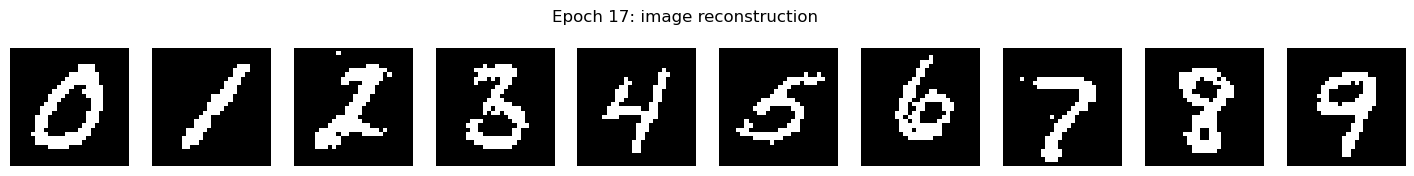

Epoch 18/20, train loss=0.026304, val loss=0.027087


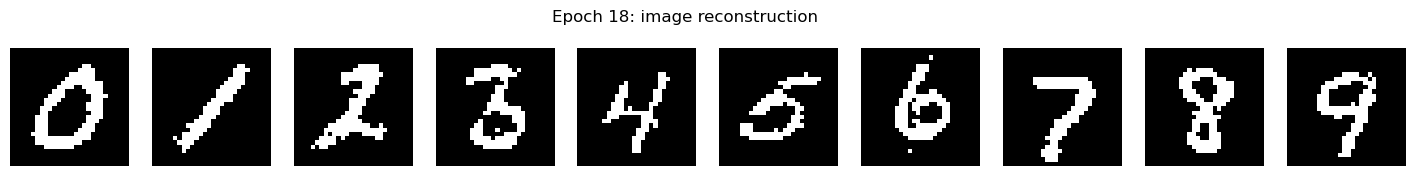

Epoch 19/20, train loss=0.026014, val loss=0.026850


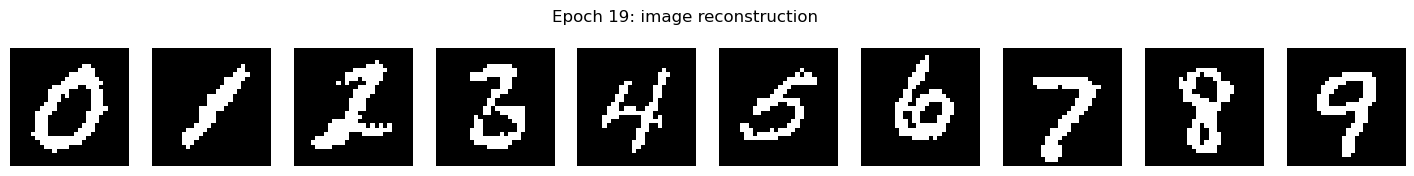

Epoch 20/20, train loss=0.025748, val loss=0.026610


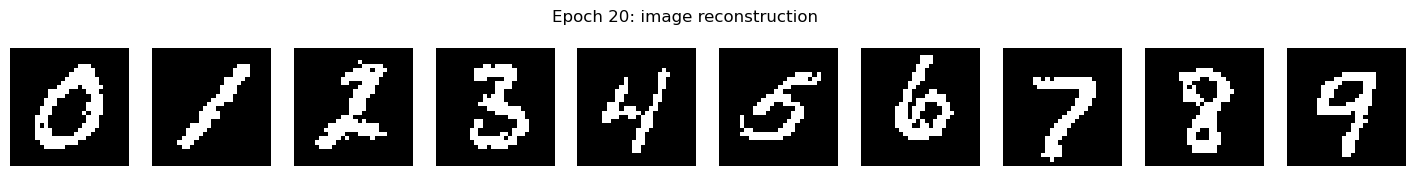

In [185]:
rbm.train()

# 3. Images Reconstuction Results

A network was pre-trained on the whole training set, which is composed of 60000 image, with the same hyperparameters described before, and a max number of epochs was set to 200. \
The model with pre-computed weigths and biases was saved in a pickle file.

## 3.1 Show Image Reconstruction Results

In [58]:
def show_RBM_results(filename, X_test, y_test):
    X_selected, _ = select_test_image(X_test, y_test)
    rbm_load, tr_errors, val_errors, best_epoch = load_RBM(filename=filename)

    rbm_load.show_reconstruction(X_selected)

    return rbm_load, tr_errors, val_errors, best_epoch

Reconstruct the original test images from their hidden encoding, then display and compare the reconstructions with the original images.

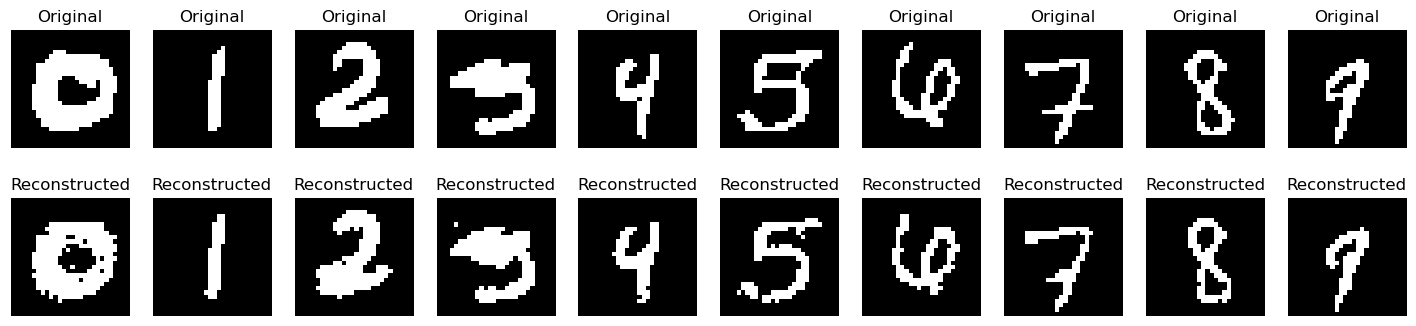

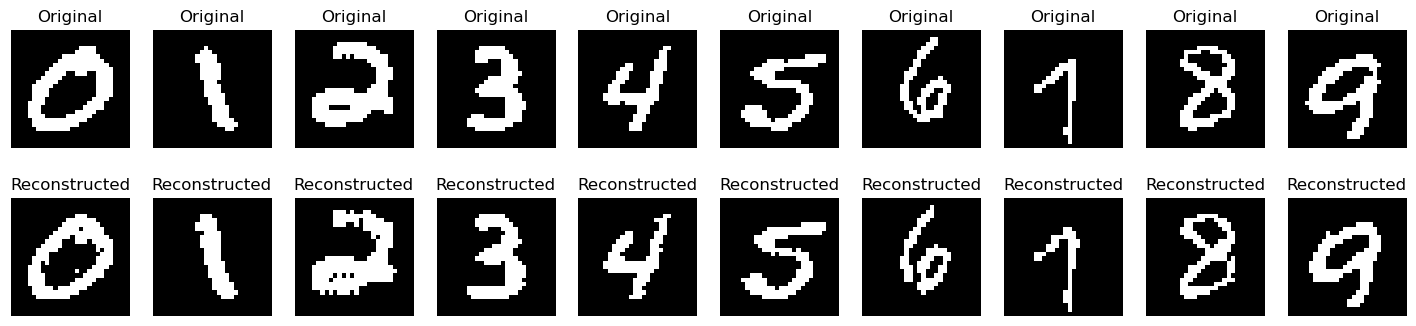

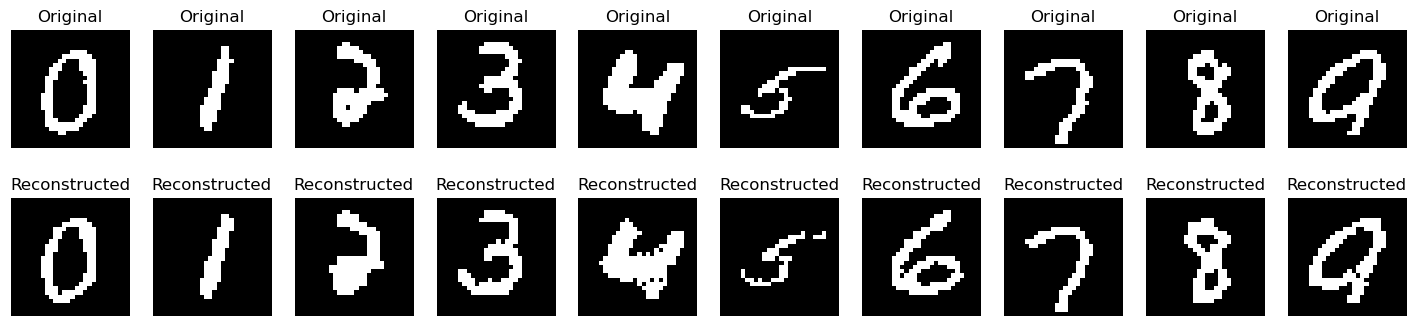

In [97]:
filename = "pickles/trained_RBM.pkl"
# first trial
rbm_load, tr_errors, val_errors, best_epoch = show_RBM_results(filename, X_test, y_test)

# second trail, showing different images set
_, _, _, _ = show_RBM_results(filename, X_test, y_test)

# third trail
_, _, _, _ = show_RBM_results(filename, X_test, y_test)

## 3.2 Show Learning curve

Reconstruction errors (MSE) are plotted below with respect to the epochs of training.

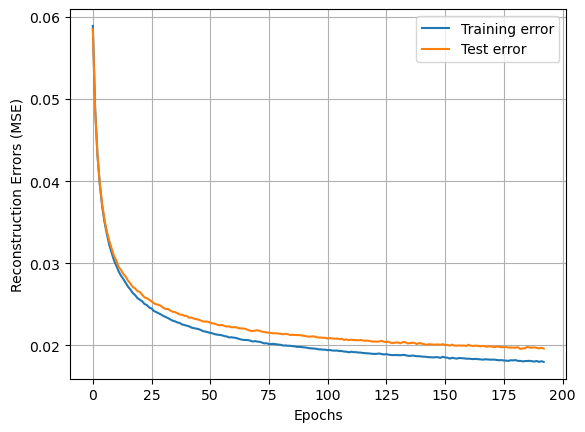

In [186]:
# show learning curve, error MSE
show_learning_curve(tr_errors, val_errors)

The algorithm stopped after 193 epochs, with the best error value reached at epoch 182. \
Below are the results:

In [61]:
print("Best epoch: %d out of %d computed" %(best_epoch, len(tr_errors)))
print("Best training error = %.6f" %tr_errors[best_epoch])
print("Best validation error = %.6f" %val_errors[best_epoch])

Best epoch: 182 out of 193 computed
Best training error = 0.018089
Best validation error = 0.019550


## 3.3 Show Final Weights

For visual purposes, the final weights of 40 out of 500 hidden units, computed by the RBM, have been plotted below.

In [176]:
def show_final_weights(weights):
    fig, ax = plt.subplots(5, 8, figsize=(18,12))
    fig.suptitle("RBM Final Weights")
    
    for i in range(40):
        w = weight_reconstruction(weights[i])
        row = int(np.floor(i/8))
        col = i % 8
        ax[row][col].imshow(w, cmap="gray")
        ax[row][col].axis("off")


def weight_reconstruction(weight):
    return weight.reshape(28, 28)

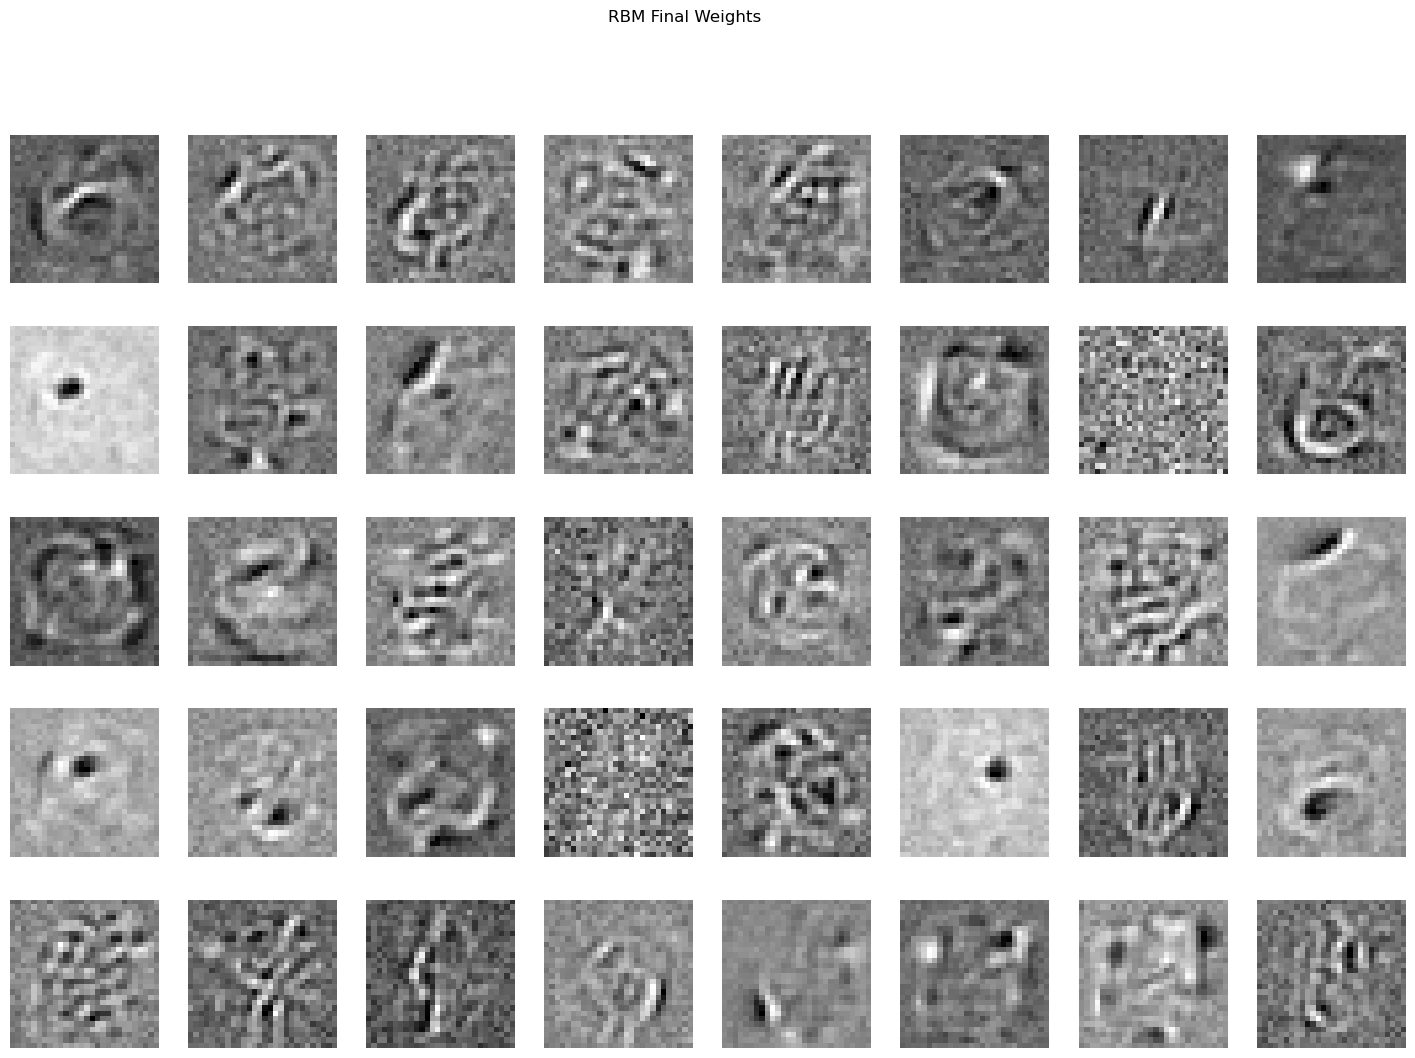

In [177]:
weights = rbm_load.M
show_final_weights(weights.T)

## 3.4 Show Reconstruction on Random Pixel Image

Below are reconstructions of a completely white image, a black one, and eight images with randomly selected black and white pixels.

In [210]:
def X_random():
    return np.where(random.rand(784) > 0.5, 1, 0)

def show_image(image_set):
    fig, ax = plt.subplots(1, 10, figsize=(18, 4))
    
    for i, image in enumerate(image_set):
        ax[i].imshow(image.reshape(28, 28), cmap="gray")
        ax[i].axis("off")
    plt.show()

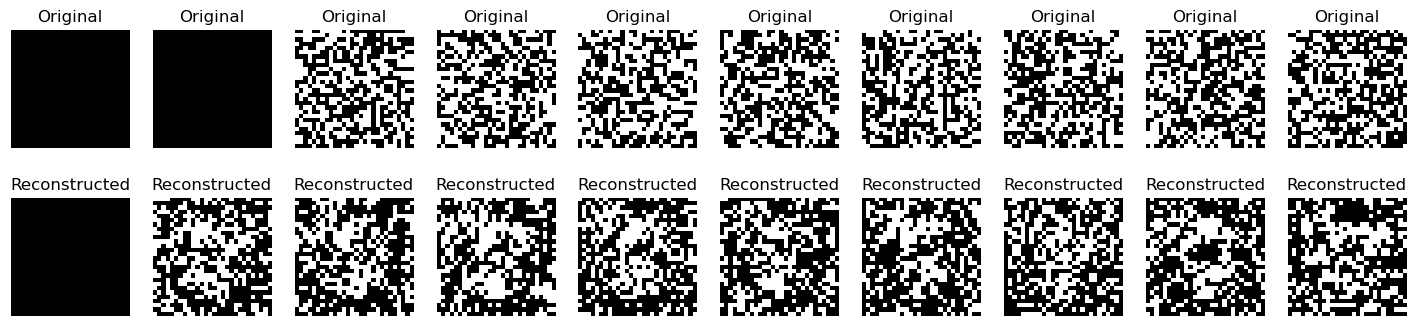

In [224]:
X_white = np.zeros(784)
X_black = np.ones(784)
X_new_test = [X_white, X_black, X_random(), X_random(), X_random(), X_random(), X_random(), X_random(), X_random(), X_random()]

# reconstructed images
rbm_load.show_reconstruction(X_new_test)

Te first trial of this test did not provide the expected results. Based on the theory, I had aspected that the model would attempt to reconstruct the digits it had learned during the training phase. However, this was not the case.

The encoding and decoding phases were performed 300 times on the same test set to observe how the output images varied.

Below are the reconstructed images every 30 iterations of the test.

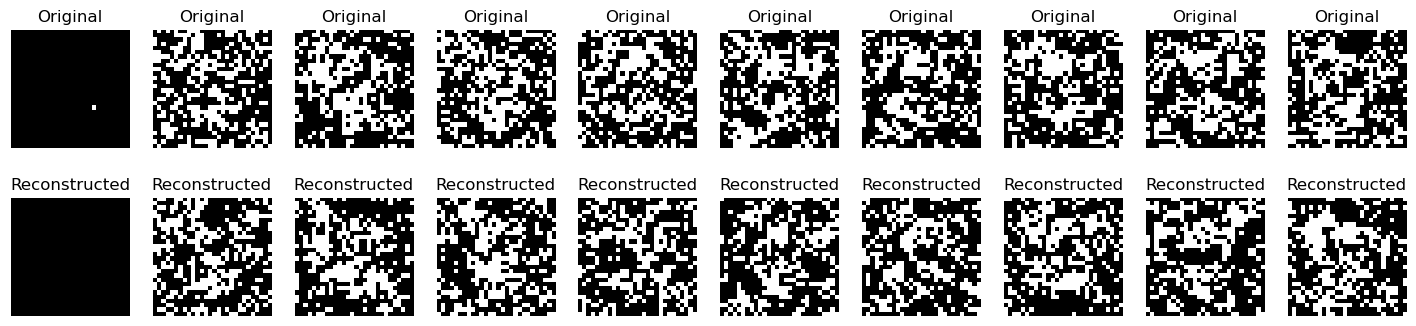

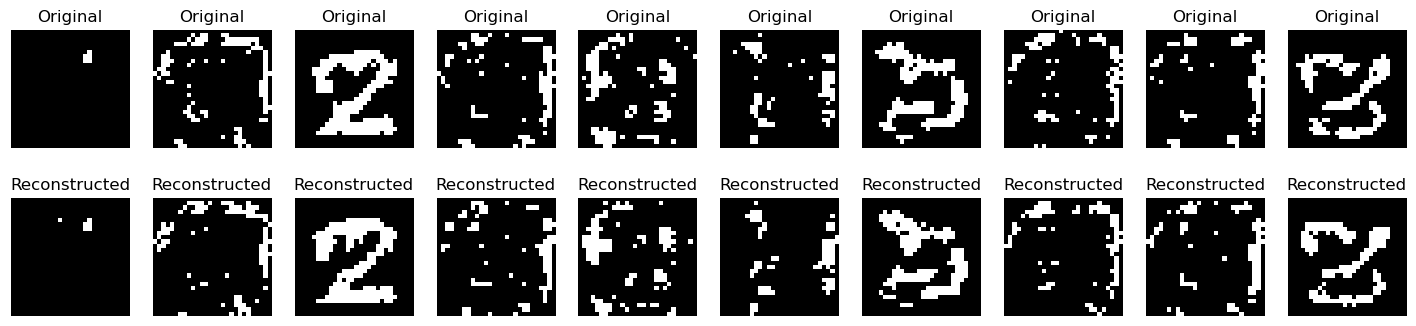

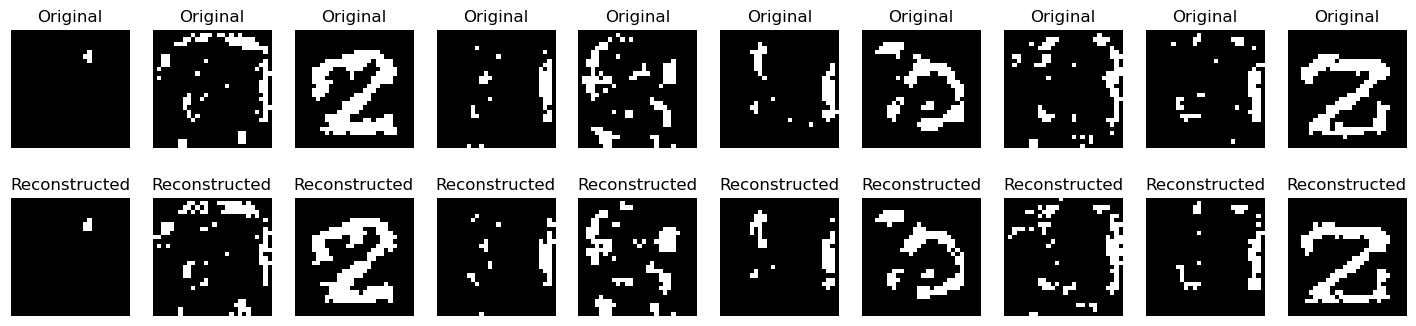

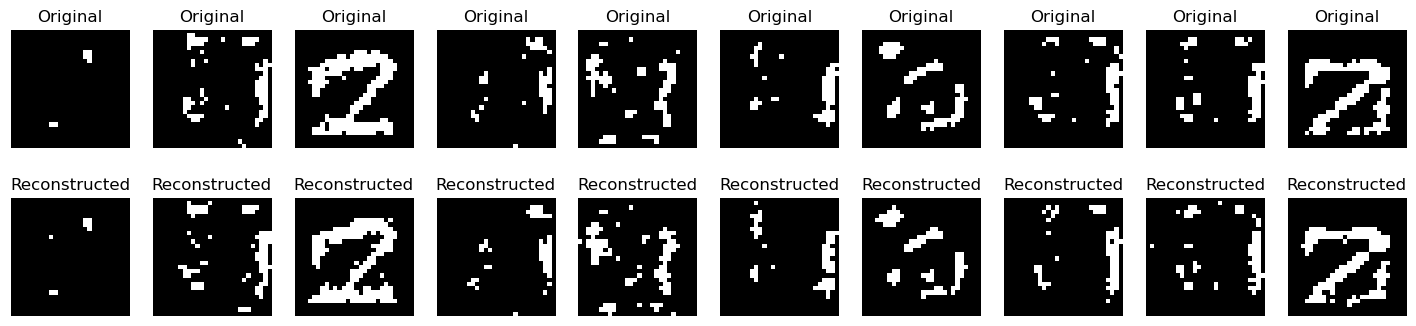

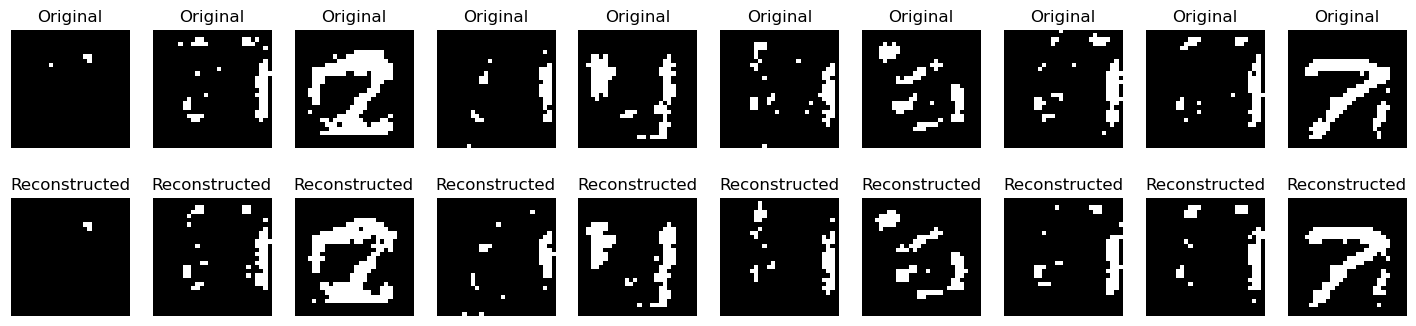

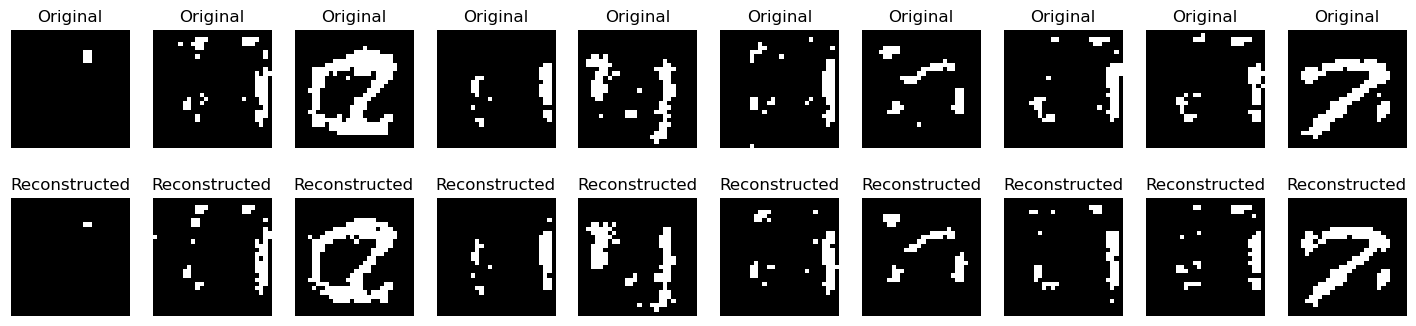

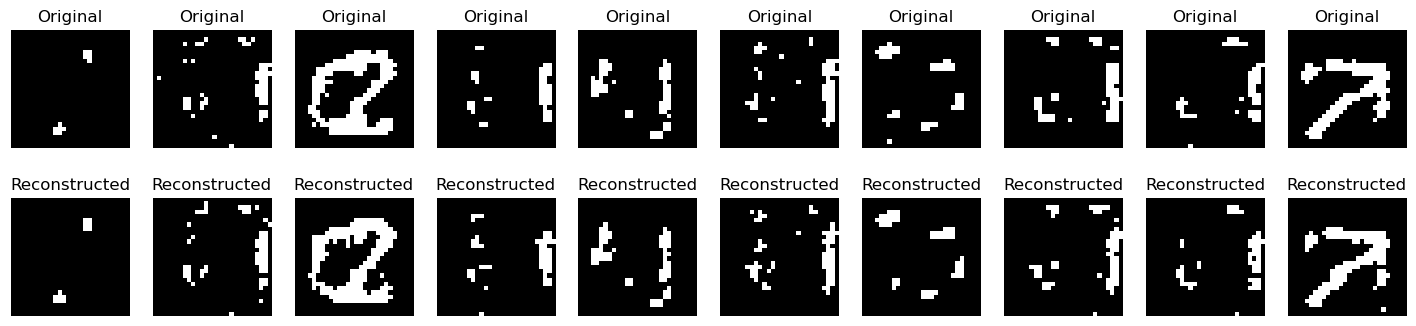

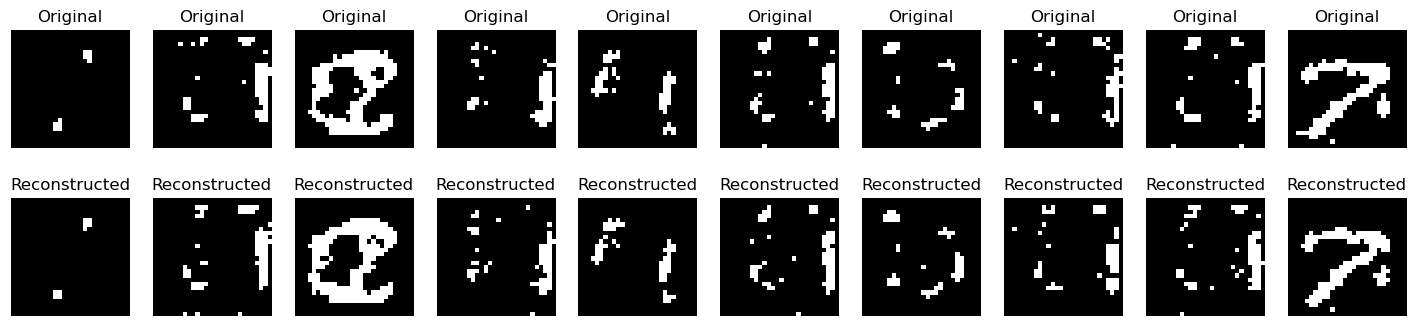

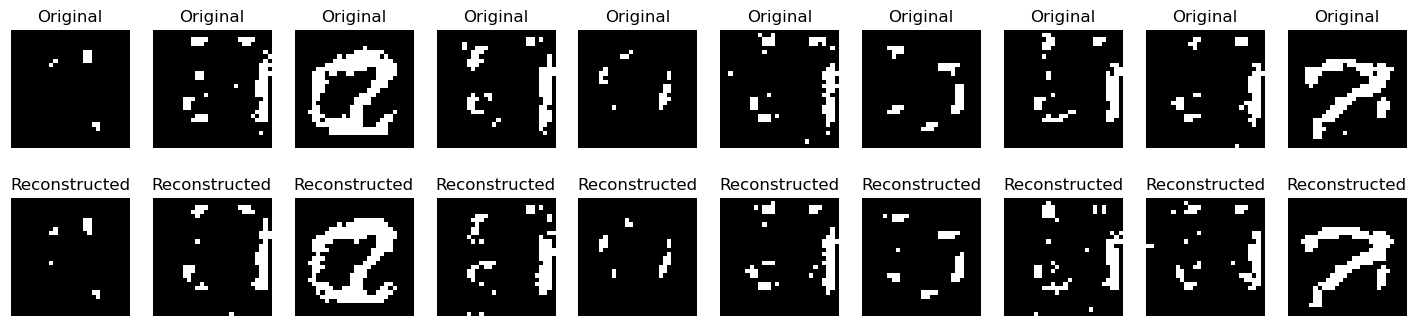

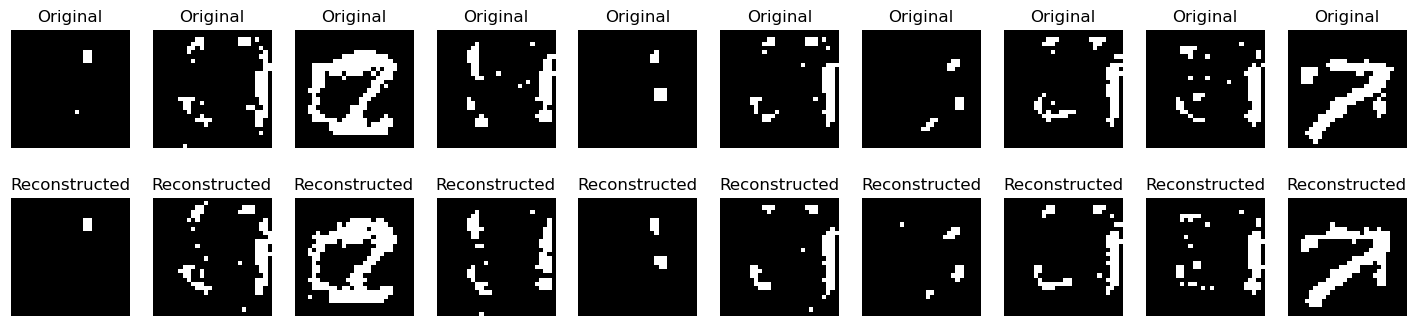

In [249]:
test_set = rbm_load.compute_reconstructed_image(X_new_test)

trials = 300
for i in range(trials):
    test_set = rbm_load.compute_reconstructed_image(test_set)
    if (i % 30) == 0: rbm_load.show_reconstruction(test_set)

This test has been carried out multiple times and also for more iterations. The digit that has emerged most frequently is 2 followed by the digits 0 and 3.

From various test runs, it has also emerged that if the images were unable to identify a digit in the initial iterations, they tended to converge to a black image.

Below are the number of examples for each digit in the training set, as can be seen there are approximately the same number of examples for each class, therefore the emergence of the digit 2 compared to the others is not due to a larger number of examples of this class in the training set.

In [264]:
labels_count = np.zeros(10)
for label in y_test:
    labels_count[label] += 1

for i in range(10):
    print("Number of examples of digit %d in trainig set = %d" %(i, labels_count[i]))

Number of examples of digit 0 in trainig set = 980
Number of examples of digit 1 in trainig set = 1135
Number of examples of digit 2 in trainig set = 1032
Number of examples of digit 3 in trainig set = 1010
Number of examples of digit 4 in trainig set = 982
Number of examples of digit 5 in trainig set = 892
Number of examples of digit 6 in trainig set = 958
Number of examples of digit 7 in trainig set = 1028
Number of examples of digit 8 in trainig set = 974
Number of examples of digit 9 in trainig set = 1009


# 4. Accuracy on Recostructed Images

The trained RBM was used to reconstruct the original test images. In order to compare the reconstructions with the original images, two different tests were conducted.

The first one involved comparing every pixel in the reconstructed images to the corresponding pixel in the original images.

The second one used a classifier to predict the labels of the test set images, after being trained with the entire training set, and then compared the predictions to the ground truth.

To obtain a numerical value for the performance of both tests, the accuracy was computed.

## 4.1 Pixel Recostruction Accuracy

To compute the accuracy score for the reconstructed images, the accuracy_score metric was used. This metric measures the percentage of binary pixels in the reconstructed images that match perfectly with the corresponding pixel in the original image.

Below, the accuracy score on the entire test set, comprising 10000 examples, is reported, along with the accuracy score for each digit. This helps to understand which digit is the most challenging to reconstruct.

In [269]:
X_test_recostr = rbm_load.compute_reconstructed_image(X_test)

image_reconstruction_accuracy = []
for original, reconstruct in zip(X_test, X_test_recostr):
    image_reconstruction_accuracy.append(accuracy_score(original, reconstruct))

accuracy_mean = np.mean(image_reconstruction_accuracy)

print("Accuracy on the reconstruction of the test set images =", accuracy_mean)

Accuracy on the reconstruction of the test set images = 0.9803895408163266


In [270]:
digit_recostruction_accuracy_sum = np.zeros(10)

for label, accuracy in zip(y_test, image_reconstruction_accuracy):
    digit_recostruction_accuracy_sum[label] += accuracy

for i, digit_accuracy in enumerate(digit_recostruction_accuracy_sum):
    print("Accuracy on images reconstruction of digit %d = %f" %(i, digit_accuracy/labels_count[i]))

Accuracy on images reconstruction of digit 0 = 0.975157
Accuracy on images reconstruction of digit 1 = 0.992395
Accuracy on images reconstruction of digit 2 = 0.975502
Accuracy on images reconstruction of digit 3 = 0.977953
Accuracy on images reconstruction of digit 4 = 0.981600
Accuracy on images reconstruction of digit 5 = 0.977867
Accuracy on images reconstruction of digit 6 = 0.978445
Accuracy on images reconstruction of digit 7 = 0.984954
Accuracy on images reconstruction of digit 8 = 0.974750
Accuracy on images reconstruction of digit 9 = 0.983095


## 4.2 Digit Classification Accuracy

The Support Vector Classifier model from the sklearn library was used as a classifier.

The model was used to predict the classification of both reconstructed and original images, in order to have a comparison.

The accuracy score was calculated by comparing the predicted labels to the actual labels using the accuracy_score metric.
This metric measures the percentage of labels in the test set that match the ground truth exactly.

The predictions are made on the entire test set, which is composed of 10000 images.

### 4.2.1 Train Classifier

In [178]:
svc_model_original = SVC()

# prediction on original images
svc_model_original.fit(X_train, y_train)
predictions_original = svc_model_original.predict(X_test)
accuracy_original = accuracy_score(y_test, predictions_original)
print("Original data")
print("Accuracy =", accuracy_original)

Original data
Accuracy = 0.9769


In [187]:
X_train_recostr = rbm_load.compute_reconstructed_image(X_train)
X_test_recostr = rbm_load.compute_reconstructed_image(X_test)

# prediction on reconstructed images
svc_model_recostr = SVC()
svc_model_recostr.fit(X_train_recostr, y_train)
predictions_recostructed = svc_model_recostr.predict(X_test_recostr)
accuracy_recostructed = accuracy_score(y_test, predictions_recostructed)
print("Recostructed data")
print("Accuracy =", accuracy_recostructed)

Recostructed data
Accuracy = 0.9719


The accuracy achieved in the test using the original images is marginally greater than that achieved with the reconstructed images.

### 4.2.2 Classification Errors

To determine which digit was most commonly misclassified, the confusion matrix for classification errors was generated for both predictions made on the original images and those made on the reconstructed images.

In [188]:
def show_confusion_matrix(y_true, predictions_original, predictions_reconstructed):
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    subfig1 = ConfusionMatrixDisplay.from_predictions(
        y_true, predictions_original, display_labels=labels, cmap=plt.cm.Purples, normalize=None)
    subfig1.ax_.set_title('Original Images')

    subfig2 = ConfusionMatrixDisplay.from_predictions(
        y_true, predictions_reconstructed, display_labels=labels, cmap=plt.cm.Blues, normalize=None)
    subfig2.ax_.set_title('Reconstructed Images')

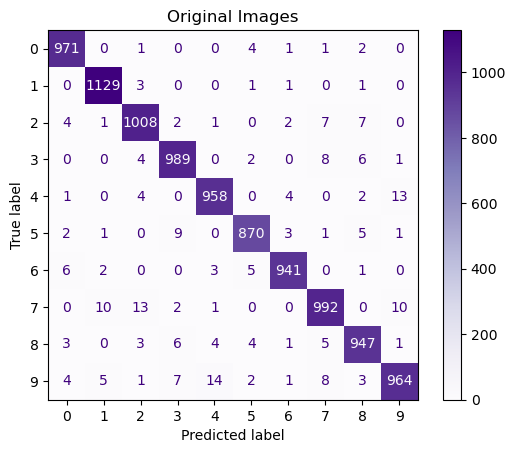

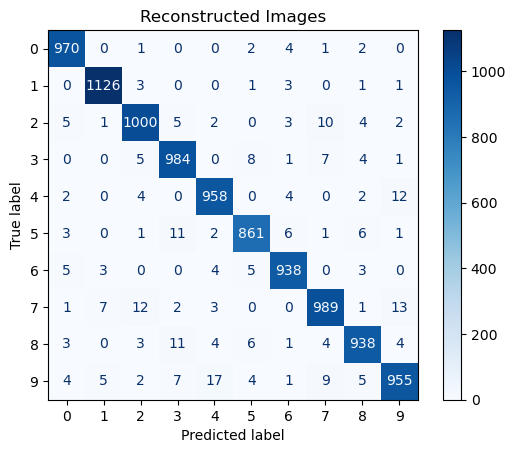

In [189]:
show_confusion_matrix(y_test, predictions_original, predictions_recostructed)

It can be observed that most classification errors occur when differentiating between digits 4 and 9 in both real and reconstructed image predictions. 
Other errors that occur with lower frequency happen between digits 3 and 5 and between 2 and 7. 

This can be explained as these digits share similar graphemes, which may lead to confusion during classification.

### 4.2.3 More Test on Classification Errors

The SVC classifiers trained earlier with original and reconstructed images were used to make predictions on a test set comprising only digits 4 and 9. The accuracy rates are displayed below. As expected, the accuracy is a little lower in the model trained with reconstructed images.

In [150]:
def divide_data_for_digit(X_data, y_data, digit1, digit2):
    X_selected = []
    y_selected = []
    
    for image, digit in zip(X_data, y_data):
        if digit == digit1 or digit == digit2:
            X_selected.append(image)
            y_selected.append(digit)
    
    return X_selected, y_selected

In [266]:
X_test_49, y_test_49 = divide_data_for_digit(X_test, y_test, digit1=4, digit2=9)
X_test_recostr_49 = rbm_load.compute_reconstructed_image(X_test_49)

# prediction on reconstructed images of digit 4 and 9
predictions_recostructed_49 = svc_model_recostr.predict(X_test_recostr_49)
accuracy_recostructed_49 = accuracy_score(y_test_49, predictions_recostructed_49)
print("Recostructed data of digits 4 and 9")
print("Accuracy =", accuracy_recostructed_49)

Recostructed data of digits 4 and 9
Accuracy = 0.9613259668508287


In [267]:
# prediction on original images of digit 4 and 9
predictions_original_49 = svc_model_original.predict(X_test_49)
accuracy_original_49 = accuracy_score(y_test_49, predictions_original_49)
print("Original data of digits 4 and 9")
print("Accuracy =", accuracy_original_49)

Original data of digits 4 and 9
Accuracy = 0.9653440482169764


# 5. Considerations

The RBM class was implemented carefully following the steps learned in class, without any particular difficulties.

The learning curve of the RBM training is not particularly smooth; perhaps by lowering the learning rate and increasing the number of epochs, it would have been possible to achieve a better result. The training phase with the selected hyperparameters lasted approximately 30 minutes, so a slower training phase could have been performed, potentially resulting in better performance.

Reconstructed images of the test set had an accuracy of 98%, matching the originals almost perfectly. \
The MNIST classification problem was resolved with accuracy exceeding 97%, even while classifying images reconstructed by the RBM.

It may have been helpful to include a data preprocessing step before feeding the data to the RBM to improve accuracy. For example, dividing the training set by labels so each batch contained the same number of examples for each label.

I am satisfied with the results obtained, although there is certainly possibility for improvement.